In [12]:
import pickle
import sys
sys.path.insert(0,'../')

import baseline
import zipreg_model 
import zipgate_reg 
from inference import *
from criticism import *
from preprocess_bikeshare import *

In [5]:
with open('../data/demand_sample.pickle', 'rb') as f:
    data_samp = pickle.load(f)

In [6]:
train = data_samp.sample(frac=0.5, random_state=42)
test = data_samp.drop(train.index)


### Baseline

In [13]:
b_data, b_features = baseline.feature_generation(train)
b = baseline.PoissReg(b_features, b_data)

In [14]:
svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                model = b.model,
                                  guide = b.guide,
                                  filename='../models/svi_baseline_params.pkl')

In [20]:
post_samples_base = posterior_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data,
    ['prediction'],
    num_samples=1000)

Text(0.5, 1.0, 'Percent of observations with 0 demand')

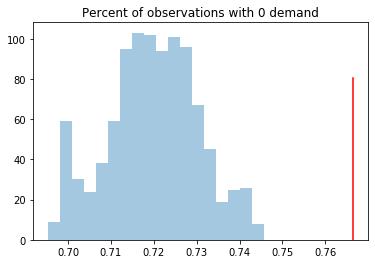

In [27]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

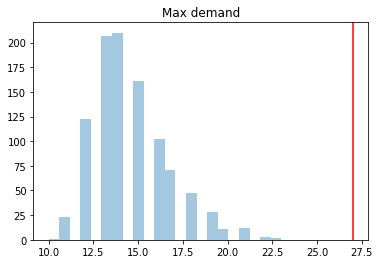

In [29]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

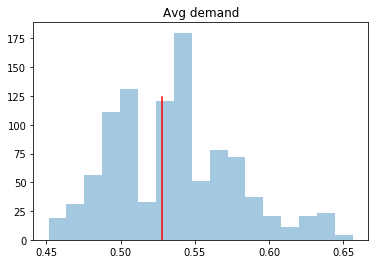

In [32]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=mean)
plt.title('Avg demand')

### ZIP (shared gate parameter)

In [15]:
z_data, z_features = zipreg_model.feature_generation(train)
z = zipreg_model.ZIPoissReg(z_features, z_data)

In [16]:
svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                model = z.model,
                                  guide = z.guide,
                                  filename='../models/svi_zip_params.pkl')

In [21]:
post_samples_zip = posterior_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data,
    ['prediction'],
    num_samples=1000)

Text(0.5, 1.0, 'Percent of observations with 0 demand')

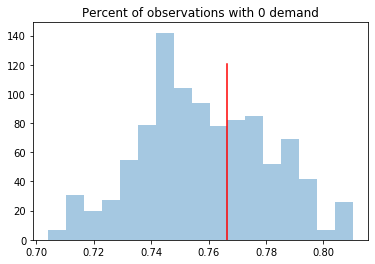

In [33]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Max demand')

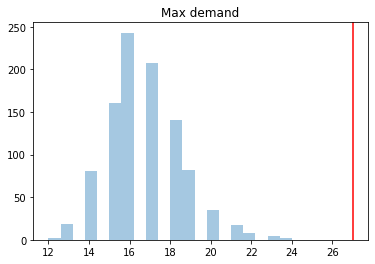

In [34]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

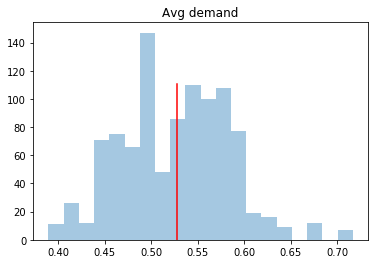

In [36]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=mean)
plt.title('Avg demand')

Text(0.5, 1.0, 'Percent of observations with 0 demand at station 70 ')

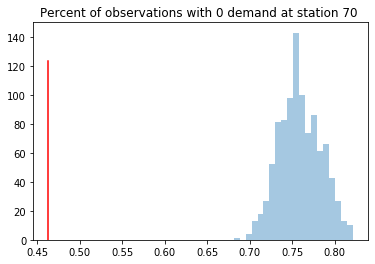

In [61]:
station_indx = (test.start_station_id==70)
compare_test_statistic(test[station_indx ].demand.values, post_samples_zip[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70')

### ZIP (logit gate parameter)

In [18]:
zg_data, zg_features = zipgate_reg.feature_generation(train)
zg = zipgate_reg.ZIPoissRegGate(zg_features, zg_data)

In [19]:
svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
                                model = zg.model,
                                  guide = zg.guide,
                                  filename='../models/svi_zipgate_params.pkl')

/Users/Sam/.pyenv/versions/3.7.2/envs/probprog/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [22]:
post_samples_zipgate = posterior_samples(
    zg.wrapped_model,
    svi_posterior_zipgate,
    zg_data,
    ['prediction'],
    num_samples=1000)

Text(0.5, 1.0, 'Percent of observations with 0 demand')

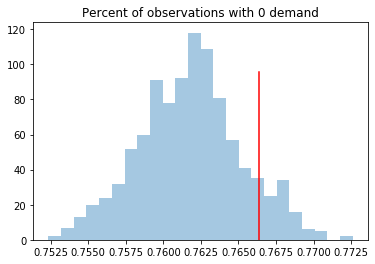

In [37]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')

Text(0.5, 1.0, 'Percent of observations with 0 demand at station 70 ')

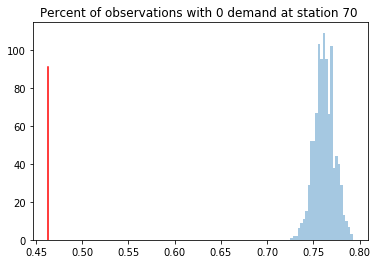

In [60]:
station_indx = (test.start_station_id==70)
compare_test_statistic(test[station_indx ].demand.values, post_samples_zipgate[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70 ')

Text(0.5, 1.0, 'Max demand')

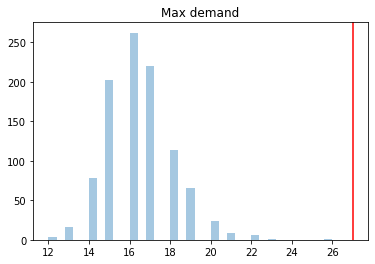

In [38]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=max_)
plt.title('Max demand')

Text(0.5, 1.0, 'Avg demand')

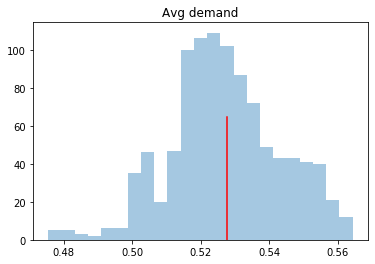

In [39]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=mean)
plt.title('Avg demand')